In [6]:
import math
import sqlite3
from datetime import datetime

import pandas as pd
import seaborn as sns

In [27]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

In [8]:
conn = sqlite3.connect('olist.db')
conn.row_factory = sqlite3.Row

In [9]:
cursor = conn.cursor()

Objektif yang akan dilakukan:

1. Melakukan analisa terhadap metode pembayaran yang banyak digunakan
2. Melihat korelasi antara skor review dengan ketepatan perkiraan pengiriman
3. Melihat korelasi antara skor review dengan status order

# Query dan Pembersihan Data

## Mengquery data

Data yang digunakan adalah data dari tabel:

1. olist_order_dataset
2. olist_order_payments_dataset
3. olist_order_reviews_dataset

Data dari ketiga tabel ini akan digunakan dalam memenuhi ketiga tujuan tadi.

In [10]:
query = '''
select ood.order_id, ood.order_purchase_timestamp purchase_timestamp,
	oopd.payment_type, oopd.payment_sequential, oopd.payment_value, ood.order_status,
	ood.order_estimated_delivery_date, ood.order_delivered_customer_date, oord.review_score 
from olist_order_dataset ood 
left join olist_order_payments_dataset oopd 
	on ood.order_id = oopd.order_id 
left join olist_order_reviews_dataset oord 
	on ood.order_id  = oord.order_id
'''
cursor.execute(query)
rows = [dict(i) for i in cursor.fetchall()]

In [11]:
olist_df = pd.DataFrame(rows)

In [12]:
olist_df.shape

(104478, 9)

### Membuat agar data sesuai dalam rentang 3 bulanan

Karena jumlah datanya cukup banyak, yaitu antara pertengahan 2016 sampai dengan pertengahan 2018 maka dalam analisanya data-data ini akan dikelompokkan dalam triwulan.
Sehingga data yang tidak genap triwulannya tidak akan masuk dalam data yang dianalisa.

In [13]:
print("Lowest date ", olist_df.purchase_timestamp.min())
print("Latest date ", olist_df.purchase_timestamp.max())

Lowest date  2016-09-04 21:15:19
Latest date  2018-10-17 17:30:18


In [14]:
olist_df = olist_df[(olist_df.purchase_timestamp >= '2016-10-01') & (olist_df.purchase_timestamp<'2018-10-01')]

In [15]:
print("Lowest date ", olist_df.purchase_timestamp.min())
print("Latest date ", olist_df.purchase_timestamp.max())

Lowest date  2016-10-02 22:07:52
Latest date  2018-09-29 09:13:03


### Mencari baris bernilai Null dan Nan

In [16]:
olist_df.isna().any()

order_id                         False
purchase_timestamp               False
payment_type                     False
payment_sequential               False
payment_value                    False
order_status                     False
order_estimated_delivery_date    False
order_delivered_customer_date     True
review_score                      True
dtype: bool

In [17]:
olist_df.isnull().any()

order_id                         False
purchase_timestamp               False
payment_type                     False
payment_sequential               False
payment_value                    False
order_status                     False
order_estimated_delivery_date    False
order_delivered_customer_date     True
review_score                      True
dtype: bool

Dari kedua pengecekan diatas diketahui bahwa ada data pada kolom order_delivered_customer_date dan kolom review_score yang kosong.
Data kosong pada review_score dapat dimaklumi karena tidak semua order yang ada, diberi review oleh pengguna.
Namun kekosongan pada review_score dapat memiliki beberapa arti, diantaranya:

1. Barang tidak sampai
2. Pesanan dibatalkan

In [19]:
olist_df[(olist_df.order_delivered_customer_date.isna())].groupby('order_status')['order_id'].count()

order_status
approved          2
canceled        656
created           5
delivered         8
invoiced        329
processing      320
shipped        1176
unavailable     651
Name: order_id, dtype: int64

Dari status pengiriman yang ada terhadap tanggal kedatangan kosong, ada yang statusnya delivered.
Untuk kasus ini berarti ada kesalahan dalam input data.
Namun karena kasusnya tidak banyak, kita bisa mengabaikan hal tersebut.

### Melihat jenis-jenis pembayaran

Kita mendapati adanya jenis pembayaran `not_defined`, namun karena status dari order tersebut adalah canceled, maka kemungkinannya adalah pelanggan belum sampai ke tahap pembayaran.
Namun review dari kasus ini tidak kosong, sehingga kita tidak bisa mengabaikan data ini.

In [198]:
olist_df.payment_type.unique()

array(['credit_card', 'voucher', 'boleto', 'debit_card', 'not_defined'],
      dtype=object)

In [200]:
olist_df[olist_df['payment_type']== 'not_defined']

,order_id,purchase_timestamp,payment_type,payment_sequential,payment_value,order_status,order_estimated_delivery_date,order_delivered_customer_date,review_score
1181,00b1cb0320190ca0daa2c88b35206009,2018-08-28 15:26:39,not_defined,1.0,0.0,canceled,2018-09-12 00:00:00,None,1.0
42007,4637ca194b6387e2d538dc89b124b0ee,2018-09-03 14:14:25,not_defined,1.0,0.0,canceled,2018-09-10 00:00:00,None,3.0
42335,c8c528189310eaa44a745b8d9d26908b,2018-08-28 20:05:14,not_defined,1.0,0.0,canceled,2018-09-11 00:00:00,None,1.0


### Menambahkan data quarter

In [21]:
def define_quarters(timestamp:str):
    year, month = timestamp.split('-')[:2]
    quarter = math.ceil(int(month)/3)
    return f'{year}.{str(quarter)}'

olist_df['quarter'] = olist_df['purchase_timestamp'].apply(define_quarters)
olist_df.sort_values('quarter', inplace=True)

# Menganalisa Metode Pembayaran

In [22]:
payment_df = olist_df[olist_df.payment_type!='not_defined'][['order_id', 'purchase_timestamp', 'payment_type', 'payment_sequential', 'payment_value', 'quarter']]

In [23]:
payment_df.head()

,order_id,purchase_timestamp,payment_type,payment_sequential,payment_value,quarter
29756,89f586f0cbddc6428831c41c8c333c66,2016-10-09 12:46:25,credit_card,1.0,44.49,2016.4
31712,92d731517f17c26f16182d45498c4c3d,2016-10-05 11:23:13,boleto,1.0,221.84,2016.4
13250,a241bea87dcdd0160ca94ebdba5bdbb9,2016-10-06 09:22:35,credit_card,1.0,297.35,2016.4
72344,7559c51df991c6861e6a8be5fb1e3751,2016-10-07 23:18:38,boleto,1.0,69.49,2016.4
65630,54bb06e1ca86bd99ee2a8d6288bf4ede,2016-10-06 13:38:39,credit_card,1.0,90.23,2016.4


Menghitung jumlah transaksi dari masing-masing jenis pembayaran pada setiap triwulannya.

In [24]:
payment_sum_df = (payment_df.groupby(['payment_type', 'quarter'], as_index=False)
                    .agg({"payment_value":"mean", "order_id":"count"})
                 )

In [25]:
payment_sum_df.head()

,payment_type,quarter,payment_value,order_id
0,boleto,2016.4,153.635873,63
1,boleto,2017.1,138.200585,1197
2,boleto,2017.2,160.609019,1988
3,boleto,2017.3,142.005046,2703
4,boleto,2017.4,145.357927,3691


Melakukan visualisasi baik dari jumlah nilai transaksi dan juga banyaknya pembayaran yang dilakukan.

<AxesSubplot:xlabel='quarter', ylabel='payment_value'>

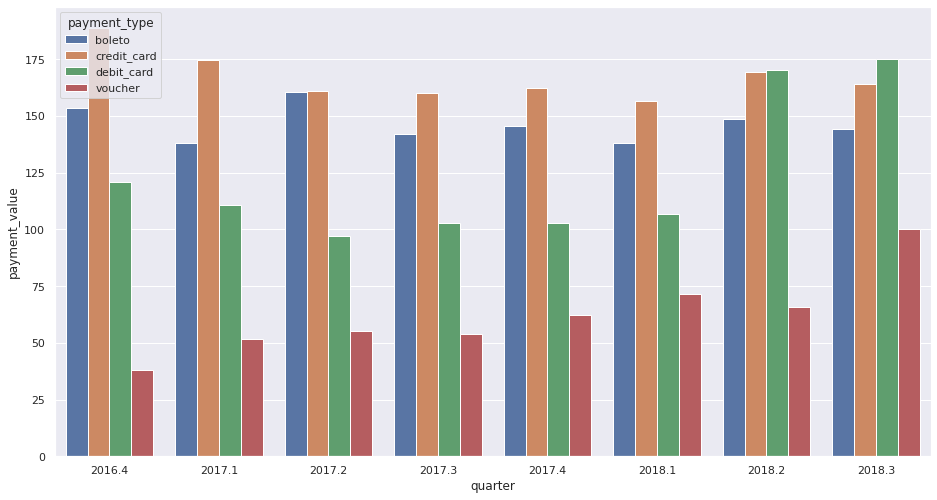

In [28]:
sns.barplot(data=payment_sum_df, x='quarter', y='payment_value', hue='payment_type')

<AxesSubplot:xlabel='quarter', ylabel='order_id'>

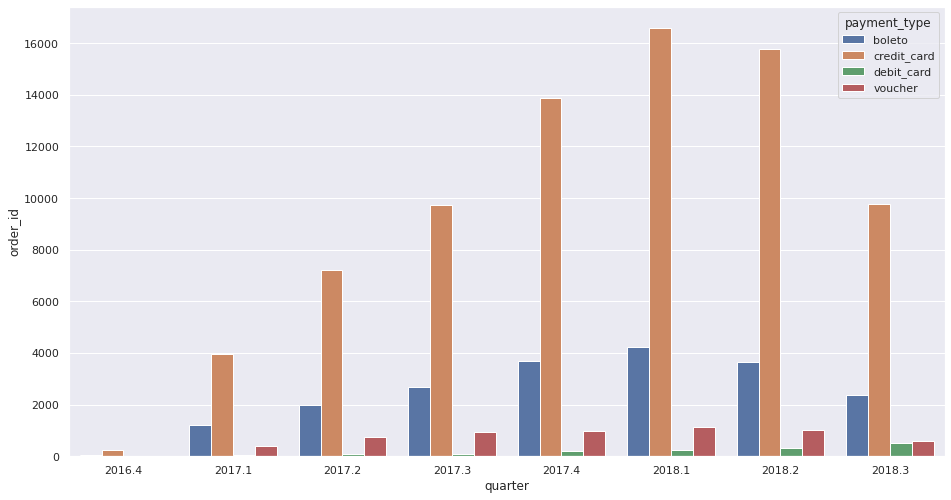

In [30]:
sns.barplot(data=payment_sum_df, x='quarter', y='order_id', hue='payment_type')

Dari kedua grafik diatas diketahui bahwa tipe pembayaran boleto, kartu kredit, dan kartu debit memiliki nilai yang cukup bersaing. Namun bila melihat dari jumlah transaksinya, maka kita dapati bahwa jumlahnya tidak berimbang. Dengan jumlah transaksi dari kartu kredit sangat tinggi, dan boleto dan kartu debit cukup rendah.

Sehingga kita juga perlu melihat rata-rata nilai transaksi dari tiap pembayaran yang ada.

In [31]:
def get_ratio(row):
    ratio = row['payment_value']/row['order_id']
    return ratio

In [32]:
payment_sum_df['ratio'] = payment_sum_df.apply(get_ratio, axis=1)

<AxesSubplot:xlabel='quarter', ylabel='ratio'>

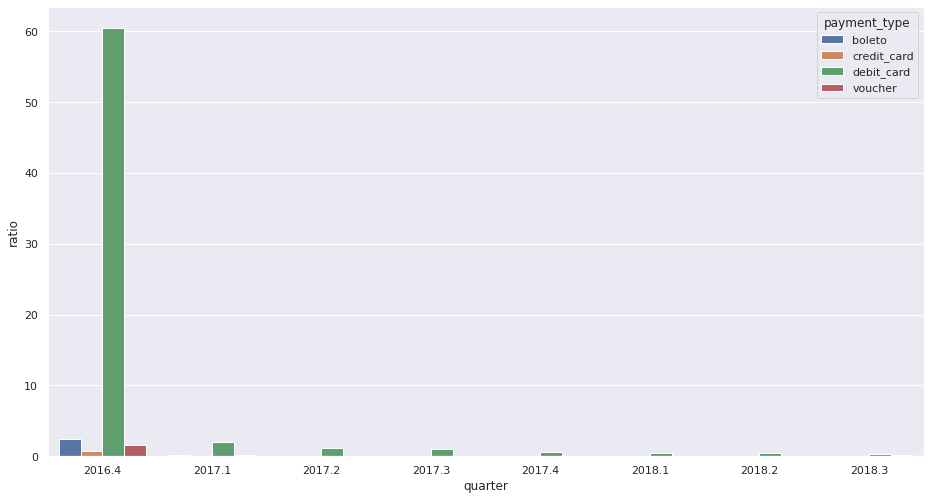

In [34]:
sns.barplot(data=payment_sum_df, x='quarter', y='ratio', hue='payment_type')

Karena data di triwulan akhir 2016 cukup berbeda dengan data setelahnya, maka untuk mempermudah analisa kita hanya akan melihat nilai rata-rata transaksi dari tahun 2017.

In [35]:
after_2017_summary_df = payment_sum_df[payment_sum_df.quarter >= '2017.1']

<AxesSubplot:xlabel='quarter', ylabel='ratio'>

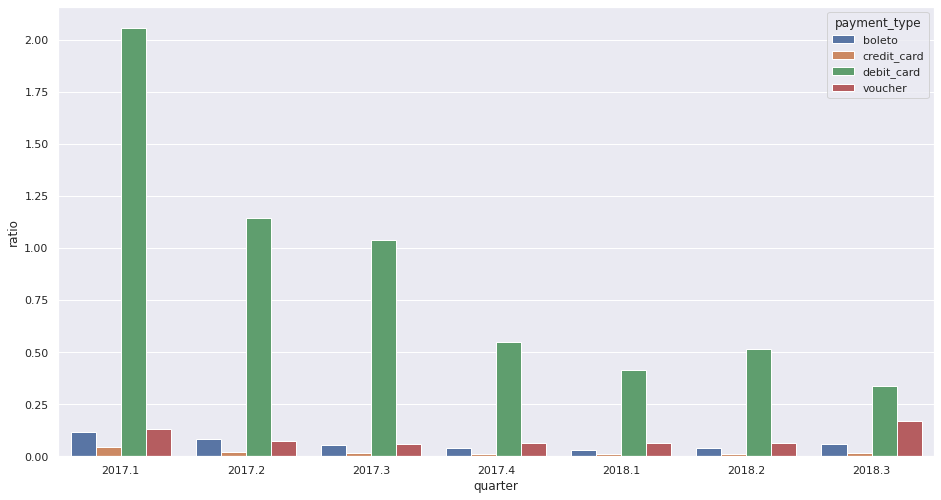

In [36]:
sns.barplot(data=after_2017_summary_df, x='quarter', y='ratio', hue='payment_type')

Dari grafik ini diketahui bahwa pengguna kartu debit adalah yang paling tinggi nilai transaksinya untuk tiap pembayaran.
Sehingga untuk menaikkan revenue ada 2 cara yang dapat dilakukan yaitu:

1. Memberikan stimulus agar para pengguna kartu kredit membelanjakan lebih banyak pada setiap transaksi
2. Memberikan stimulus agar pengguna kartu debit melakukan transaksi lebih banyak dengan nilai transaksi yang tidak jauh berbeda dengan saat ini

# Analisa Korelasi Antara Review Dengan Ketepatan Perkiraan Pengiriman

Asumsi yang ada adalah, untuk order yang berhasil tersampaikan pada konsumen, pengaruh utama dari review negatif adalah lamanya pengiriman.

In [37]:
used_columns =['order_id', 'quarter', 'order_estimated_delivery_date', 'order_delivered_customer_date', 'review_score'] 
delivery_df = olist_df[(olist_df.order_status=='delivered') & (olist_df.order_delivered_customer_date.notnull())][used_columns]

In [38]:
renamed_columns = {
    'order_id':'order',
    'order_estimated_delivery_date': 'estimated',
    'order_delivered_customer_date': 'actual',
    'review_score': 'review'
}
delivery_df.rename(mapper=renamed_columns, axis=1, inplace=True)

In [39]:
delivery_df.head()

,order,quarter,estimated,actual,review
29756,89f586f0cbddc6428831c41c8c333c66,2016.4,2016-12-02 00:00:00,2016-10-17 02:55:39,5.0
13250,a241bea87dcdd0160ca94ebdba5bdbb9,2016.4,2016-11-28 00:00:00,2016-10-13 16:03:06,5.0
72344,7559c51df991c6861e6a8be5fb1e3751,2016.4,2016-12-01 00:00:00,2016-10-26 14:47:42,3.0
17439,ad1aeeb1a99c9f021e38a49865bb812c,2016.4,2016-12-09 00:00:00,2016-10-26 13:31:53,5.0
103471,9d664ec86be69d869bb6870294c4fdd8,2016.4,2016-12-12 00:00:00,2016-10-31 11:35:45,4.0


In [40]:
delivery_df.groupby('review')['order'].count()

review
1.0     9846
2.0     3093
3.0     8314
4.0    19848
5.0    59540
Name: order, dtype: int64

Kita akan menghitung selisih dari perkiraan sampai dengan aktual sampainya paket ke tangan konsumen.
Semakin besar nilai delivery_diff, maka paket sampai ke konsumen lebih lama.

In [43]:
def define_differences(row):
    if row['actual']<row['estimated']:
        return 0
    
    estimated = datetime.strptime(row['estimated'], '%Y-%m-%d %H:%M:%S')
    actual = datetime.strptime(row['actual'], '%Y-%m-%d %H:%M:%S')
    delta = actual - estimated
    return delta.days

In [44]:
delivery_df['delivery_diff'] = delivery_df.apply(define_differences, axis=1)

<AxesSubplot:xlabel='review', ylabel='delivery_diff'>

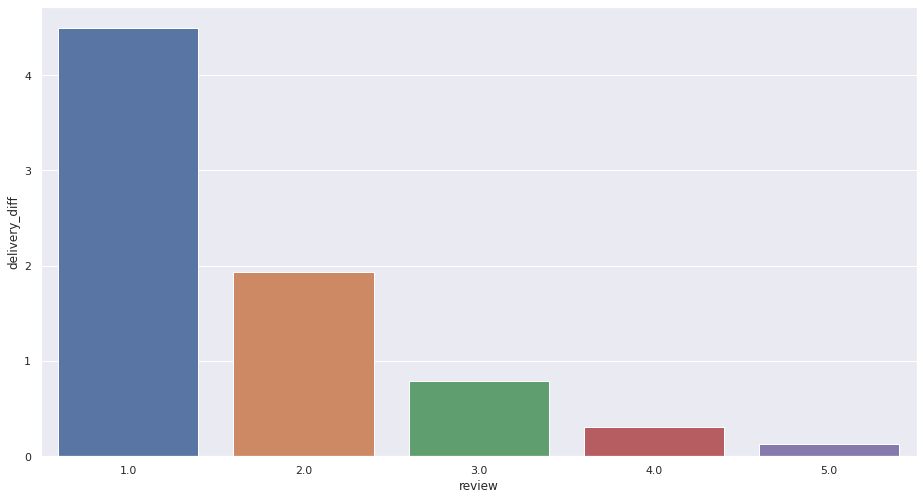

In [51]:
review_delivery_diff_df = delivery_df.groupby('review')['delivery_diff'].mean().reset_index()
sns.barplot(data = review_delivery_diff_df, x='review', y='delivery_diff')

Dari grafik ini kita dapat melihat bahwa keterlambatan memang menentukan review pengguna.
Namun tidak cukup signifikan untuk dilakukan pengambilan keputusan.
Karena dapat dilihat bahwa antara review dengan bintan 5, 4, dan 3 masih berada dalam selisih 1 hari pengiriman.
Yang paling terlihat memang keterlambatan untuk review bintang 1, dimana umumnya terlambat lebih dari 4 hari.

Sehingga dari kesimpulan diatas, kita tidak dapat menggunakan variabel keterlambatan order untuk perbaikan review.

# Analisa Korelasi Antara Review Dengan Status Order

In [53]:
used_columns =['order_id', 'order_status', 'review_score'] 
status_df = olist_df[olist_df.review_score.notnull()][used_columns]

In [54]:
renamed_columns = {
    'order_id':'order',
    'order_status': 'status',
    'review_score': 'review'
}
status_df.rename(mapper=renamed_columns, axis=1, inplace=True)

In [55]:
status_review_df = status_df.groupby('status')['review'].median().reset_index().sort_values('review')

<AxesSubplot:xlabel='status', ylabel='review'>

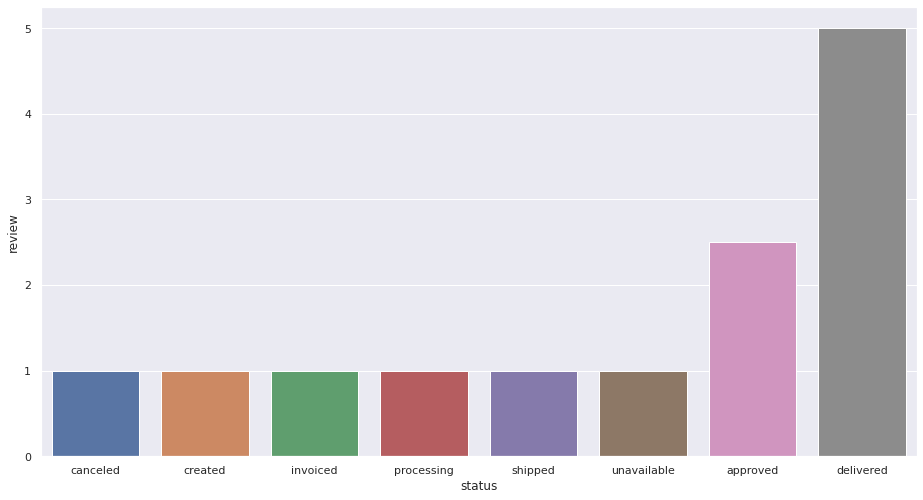

In [56]:
sns.barplot(data=status_review_df, x='status', y='review')

Dari sini terlihat bahwa order yang pasti berakibat buruk terhadap review adalah order dengan status akhir:

1. canceled
2. created
3. invoiced
4. processing
5. shipped
6. unavailable

Sehingga kita perlu melakukan analisa lebih jauh terhadap data-data order yang lampau dengan 6 status tadi.